Copyright (c) 2000 Jabavu W. Adams

In [1]:
import numpy as np
import tensorflow as tf

In [2]:
print(tf.__version__)
print(tf.keras.__version__)

2.2.0
2.3.0-tf


In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 8)

Load Images
==

In [4]:
import PIL
print(PIL.__version__)
from PIL import Image
from PIL import ImageOps

7.2.0


In [5]:
import os

DATA_ROOT = os.path.expanduser('~/devel/polkaspots/polkaspots_dataset')
DATA_PARENT = os.path.abspath(os.path.join(DATA_ROOT, '..'))

IMG_ROOT = os.path.join(DATA_ROOT, 'images')
POS_ROOT = os.path.join(DATA_ROOT, 'positions')

In [6]:
import glob
import re
import zipfile

radii = []
dot_counts = []

zip_files = glob.glob(os.path.join(IMG_ROOT, 'radius*.zip'))
for zf in zip_files:
    unzipped_file_name = os.path.splitext(zf)[0]
    if not os.path.exists(unzipped_file_name):
        with zipfile.ZipFile(zf, 'r') as zip_ref:
            zip_ref.extractall(DATA_PARENT)

    m = re.search('radius([0-9]+)', unzipped_file_name)
    assert(m)
    radius = int(m[1])
    radii.append(radius)

max_radius = max(radii)
min_radius = min(radii)
print(f'radius: {min_radius} -> {max_radius}')

radius: 2 -> 40


In [7]:
for radius in range(min_radius, max_radius+1):
    if not len(dot_counts):
        unzipped_dirs = glob.glob(os.path.join(IMG_ROOT, f'radius{radius:02d}/*'))
        assert(len(unzipped_dirs))
        for uzd in unzipped_dirs:
            first_unzipped_dir = unzipped_dirs[0]
            m = re.search('radius([0-9]+)', first_unzipped_dir)
            dot_counts.append(int(m[1]))
        
min_dot_count = min(dot_counts)
max_dot_count = max(dot_counts)
print(min_dot_count, max_dot_count)

2 2


In [8]:
def image_count(nb_dots, radius):
    """Return the number of images containing the given number of dots of the given radius."""
    containing_path = os.path.join(IMG_ROOT, f'radius{radius:02d}', f'{nb_dots:02d}')
    file_wildcard = f'dots_radius_{radius}_count_{nb_dots:02d}_*.png'
    filenames = glob.glob(os.path.join(containing_path, file_wildcard))
    return len(filenames)

In [9]:
def get_image(nb_dots, radius, i):
    """Get the ith image with the given number of dots of the given radius. Returns a PIL.Image"""
    containing_folder = os.path.join(IMG_ROOT, f'radius{radius:02d}', f'{nb_dots:02d}')
    filename = f'dots_radius_{radius}_count_{nb_dots:02d}_{i:05d}.png'
    return Image.open(os.path.join(containing_folder, filename))

In [10]:
im = get_image(7, 20, 42)

PNG
RGB
(256, 256)


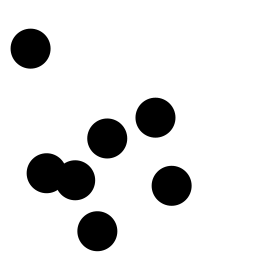

In [11]:
print(im.format)
print(im.mode)
print(im.size)
im

In [12]:
# Convert to from RGB to grayscale
im = im.convert(mode='L')
print(im.mode)
print(im.size)

# Invert image so blobs are high and background is low
im = ImageOps.invert(im)
im.show()

L
(256, 256)


In [13]:
# Convert to numpy array and convert values from 0 -> 255 to 0.0 -> 1.0
x = np.asarray(im) / 255.0
print(x)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [14]:
def array_for_image(nb_dots, radius, i):
    """Get the ith image with the given number of dots of the given radius. Returns a NumPy array of float.
    The array is one channel (grayscale), background pixels are 0.0, and dot pixels are 1.0."""
    im = get_image(nb_dots, radius, i)
    im = im.convert(mode='L')
    im = ImageOps.invert(im)
    return np.asarray(im) / 255.0

In [15]:
array_for_image(8, 32, 100)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Create training, validation, and test dataset splits

In [16]:
import hickle as hkl

In [17]:
# from sklearn.model_selection import train_test_split

# image_arrays = []
# dot_counts = []
# for radius in range(2, 40+1):
#     print(radius)
#     for nb_dots in range(10+1):
#         #print(nb_dots)
#         for i in range(image_count(nb_dots, radius)):
#             image_arrays.append(array_for_image(nb_dots, radius, i))
#             dot_counts.append(nb_dots)

# nb_all_images = len(image_arrays)
                 
# inputs = np.zeros((nb_all_images, image_arrays[0].shape[0], image_arrays[0].shape[1], 1), np.uint8)
# labels = np.zeros((nb_all_images, 1), np.uint8)

# for i in range(nb_all_images):
#     inputs[i] = image_arrays[i].reshape((image_arrays[0].shape[0], image_arrays[0].shape[1], 1))
#     labels[i] = dot_counts[i]

# del image_arrays
# del dot_counts

# (trainX, testX, trainY, testY) = train_test_split(inputs, labels, test_size=0.2, random_state=301)

# hkl.dump(trainX, 'X_train.hkl')
# del trainX

# hkl.dump(trainY, 'Y_train.hkl')
# del trainY

# hkl.dump(testX, 'X_test.hkl')
# del testX

# hkl.dump(testY, 'Y_test.hkl')
# del testY


In [18]:
X_train = hkl.load('X_train.hkl')
Y_train = hkl.load('Y_train.hkl')

# Build Model and Train

In [19]:
from tensorflow import keras
from tensorflow.keras import layers

n_rows = X_train.shape[1]
n_cols = X_train.shape[2]

width_px = n_cols
height_px = n_rows

model = keras.Sequential()
model.add(layers.Conv2D(32, (7, 7), activation="relu", input_shape=(n_rows, n_cols, 1)))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(32, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(32, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(32, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(32, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(32, (3, 3), activation="relu"))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation="relu"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 250, 250, 32)      1600      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 123, 123, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 59, 59, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 32)        9

In [20]:
model.compile(optimizer="adam", loss="MeanSquaredError")

## Load existing model (if any) and continue training.

In [26]:
from tensorflow.keras.models import load_model

model_files = glob.glob('./models/polkaspots_epoch_*.hdf5')
if len(model_files):
    model_epochs = [int(fn_[-8:-5]) for fn_ in model_files]
    highest_completed_epoch = max(model_epochs)
    model = load_model(f'./models/polkaspots_epoch_{highest_completed_epoch:03d}.hdf5')
else:
    highest_completed_epoch = 0

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

callbacks = []
callbacks.append(ModelCheckpoint(filepath='./models/polkaspots_epoch_{epoch:03d}.hdf5', monitor='val_loss'))

history = model.fit(X_train, Y_train, batch_size=20, epochs=10, initial_epoch=highest_completed_epoch, callbacks=callbacks)

Epoch 2/10
3432/3432 [==============================] - 1648s 480ms/step - loss: 0.5477
Epoch 3/10
2648/3432 [======================>.......] - ETA: 6:16 - loss: 0.4549